# Kaggle
# Credit Card Fraud Detection
Anonymized credit card transactions labeled as fraudulent or genuine

### ※ imblearn 설치하는 이유

DataSet Class_Column(Label)의 Value_counts를 확인해보면

값이 1(사기 트랜잭션)에 해당하는 비율이 전체의 0.172% 뿐이다.

이런 경우 학습이 제대로 되지 않기 때문에 적절한 학습 데이터를 확보해야 한다.

이 때 사용하는 것이 imblearn의 Oversampling/Undersampling 이다.

- Undersampling : 많은 데이터 세트를 적은 데이터 세트 수준으로 감소.
- Oversampling : 적은 데이터 세트를 증식하여 충분한 데이터 확보. SMOTE 방법 사용

In [3]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

card_df = pd.read_csv('creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# Time Column의 경우 큰 의미 없는 데이터이므로 제거.
# 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy


# 사전 데이터 가공 및 학습/테스트 데이터 세트를 반환.
def get_train_test_dataset(df=None):
    
    df_copy = get_preprocessed_df(df)
    
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, 
                                                        test_size=0.3, random_state=0, 
                                                        stratify=y_target)
    
    print(' 학습 데이터 레이블 값 비율')
    print(y_train.value_counts()/y_train.shape[0] * 100)
    print('\n 테스트 데이터 레이블 값 비율')
    print(y_test.value_counts()/y_test.shape[0] * 100)
    
    return X_train, X_test, y_train, y_test



X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

 학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64

 테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


# SMOTE Oversampling 적용 전 모델 학습/예측/평가

## 로지스틱 회귀

In [10]:
# 3장에서 생성한 예측성능 평가모델 Load
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [11]:
# 모델 생성
lr_clf = LogisticRegression()

# 학습 및 예측
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 모델 성능평가 수행. 
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85282    13]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8762, 재현율: 0.6216, F1: 0.7273, AUC:0.9555


## LightGBM

In [12]:
# 모델을 변경해 반복적으로 학습/예측/평가 진행할 예정
# 이를 한 번에 수행해주는 함수 생성
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [13]:
# LightGBM 모델 생성
# boost_from_average 파라미터 False로 설정
# 미설정시 데이터 분포가 불균형한 세트에서 AUC 성적이 크게 저하됨.
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, F1: 0.8453, AUC:0.9790


## 데이터 분포 변환 후 학습/예측/평가

### 1. 분포도 확인

<AxesSubplot:xlabel='Amount', ylabel='Density'>

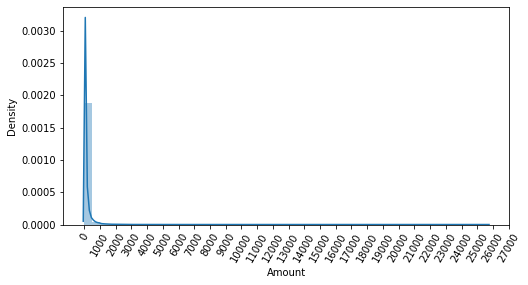

In [14]:
# Amount는 신용카드 사용 금액 Feature
# 정상/사기 트랜잭션을 결정하는데 매우 중요한 속성일 가능성 존재.
# 해당 Feature에 대한 분포도 확인
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

### 2.1 StandardScaler 정규화

In [15]:
# 사용 금액이 1000불 이하인 데이터가 대부분이므로 정규화 진행.
# 로지스틱 회귀 사용하여 성능 예측

# StandardScaler로 Amount Feature 정규분포 형태로 변환.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    
    # 변환된 Amount를 Amount_Scaled로 DataFrame맨 앞에 삽입.
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount Feature 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    return df_copy

In [17]:
# Amount Feature 정규분포 형태로 변환.
# 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('\n=== 로지스틱 회귀 예측 성능 ===')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('\n=== LightGBM 예측 성능 ===')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

 학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64

 테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64

=== 로지스틱 회귀 예측 성능 ===
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC:0.9702

=== LightGBM 예측 성능 ===
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500, F1: 0.8409, AUC:0.9779


### 2.2 Log 정규화

In [18]:
# 원래 값에 log값으로 적용.
# 큰 값을 상대적으로 작은 값으로 변환.
# Numpy log1p() 함수 사용.

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    
    # Numpy log1p() 사용하여 Amount Feautre값 Log 변환 
    amount_n = np.log1p(df_copy['Amount'])
    
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    return df_copy


# Amount Feature Log 형태로 변환.
# 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('\n=== 로지스틱 회귀 예측 성능 ===')
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('\n=== LightGBM 예측 성능 ===')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

 학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64

 테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64

=== 로지스틱 회귀 예측 성능 ===
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC:0.9727

=== LightGBM 예측 성능 ===
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, AUC:0.9796


### 이상치 제거

<AxesSubplot:>

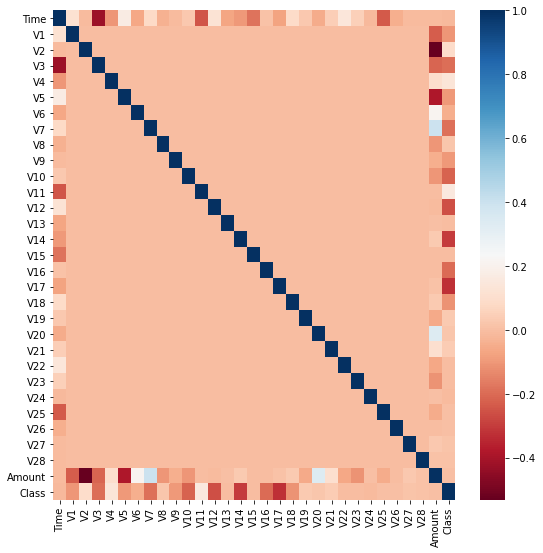

In [19]:
# IQR 방식 적용.

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [20]:
# Label값인 Class Feature와 음의 상관관계가 가장 높은 Feature는 V14, V17
# 둘 다 해야하지만 예제이므로 V14에 대해서만 이상치 제거 수행
# percentile() 함수를 이용하여 각 분위수 도출.
# 계산한 IQR에 1.5 곱하여 최대/최소 지점 도출.
# 이를 벗어난 값을 이상치로 설정하고 해당 Index 반환하는 함수 생성.

def get_outlier(df=None, column=None, weight=1.5):
    
    # fraud에 해당하는 column 데이터만 추출 
    fraud = df[df['Class']==1][column]
    
    # 1/4 및 3/4 분위 값 도출.
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    # IQR설정 및 최대/최소값 도출. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 범위를 벗어나는 값을 이상치로 설정. 해당 값 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index


# V14 Feature에 존재하는 이상치 index 도출
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [21]:
# get_processed_df( )수정.
# 로그 변환 정규화 수행 후 V14 피처의 이상치 삭제 로직 추가. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    # 이상치 데이터 삭제 로직
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    
    return df_copy


X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)


print('\n=== 로지스틱 회귀 예측 성능 ===')
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)
print('\n=== LightGBM 예측 성능 ===')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

 학습 데이터 레이블 값 비율
0    99.828453
1     0.171547
Name: Class, dtype: float64

 테스트 데이터 레이블 값 비율
0    99.829122
1     0.170878
Name: Class, dtype: float64

=== 로지스틱 회귀 예측 성능 ===
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC:0.9743

=== LightGBM 예측 성능 ===
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288, F1: 0.8897, AUC:0.9780


# 
# SMOTE Oversampling 적용 후 모델 학습/예측/평가

In [24]:
# imbalanced-learn 패키지 SMOTE 클래스 이용하여 구현.
# 반드시 학습 데이터 세트만 샘플링 할 것에 주의.

# SMOTE 객체 생성
smote = SMOTE(random_state=0)

# 샘플링 수행
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: ')
print(pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
1    199020
0    199020
Name: Class, dtype: int64


In [25]:
# 전체 데이터 세트가 2배 가량 증가함.
# 이를 이용하여 로지스틱 회귀 모델 학습/예측/평가 수행


# 모델 생성
lr_clf = LogisticRegression()


# SMOTE로 Oversampling한 X_train_over와 y_train_over 대입.
# Test Data는 변경값 없음에 유의.
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC:0.9737


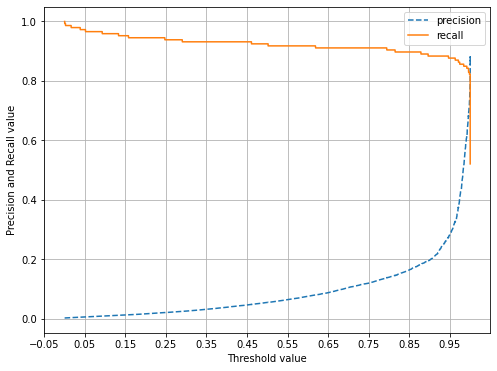

In [27]:
# 정확도 및 재현율이 크게 증가.
# 다만 정밀도, F1스코어가 크게 감소.
# 이는 Oversampling으로 인해 Fraud값이 큰 폭으로 상승했기 때문으로 추정.
# 3장에서 사용한 precision_recall_curve_plot 이용하여 회귀모델 시각화하여 검증 시작.

def precision_recall_curve_plot(y_test , pred_proba_c1):
    
    # threshold와 이에 따른 정밀도, 재현율 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축 threshold, Y축 정밀도, 재현율로 각각 Plot 수행. 정밀도는 점선으로 표시.
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
    
# 로지스틱 회귀 모델 시각화
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [28]:
# 대략 임계값 0.99에서 정밀도 및 재현율 최고성능.
# 다만 임계값 민감도가 최고 수준에서 발생하는 현상이므로 패스.
# 즉 로지스틱 회귀 모델에서 SMOTE 적용하기 힘듦.
# 따라서 LightGBM 모델에서 재측정.


lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493, F1: 0.8794, AUC:0.9814


In [36]:
# 정밀도는 증가했지만 재현율은 약간 감소한 수치.
# SMOTE 적용시 정밀도가 증가하고 재현율이 감소하는게 일반적.
# 즉 효과적으로 데이터 증식했음을 알 수 있음.

#정리
No_logistic = ['원본 데이터 가공 없음', 'Logistic', 0.9992, 0.8762, 0.6216, 0.7273, 0.9555]
No_LGBM = ['원본 데이터 가공 없음', 'LightGBM', 0.9995, 0.9573, 0.7568, 0.8453, 0.9790]

Standard_logistic = ['데이터 Standard 변환', 'Logistic', 0.9992, 0.8654, 0.6081, 0.7143, 0.9702]
Standard_LGBM = ['데이터 Standard 변환', 'LightGBM', 0.9995, 0.9569, 0.7500, 0.8409, 0.9779]

Log_logistic = ['데이터 Log 변환', 'Logistic', 0.9992, 0.8812, 0.6014, 0.7149, 0.9727]
Log_LGBM = ['데이터 Log 변환', 'LightGBM', 0.9995, 0.9576, 0.7635, 0.8496, 0.9796]

Outlier_logistic = ['이상치 제거', 'Logistic', 0.9993, 0.8750, 0.6712, 0.7597, 0.9743]
Outlier_LGBM = ['이상치 제거', 'LightGBM', 0.9996, 0.9603, 0.8288, 0.8897, 0.9780]

SMOTE_logistic = ['SMOTE', 'Logistic', 0.9723, 0.0542, 0.9247, 0.1023, 0.9737]
SMOTE_LGBM = ['SMOTE', 'LightGBM', 0.9996, 0.9118, 0.8493, 0.8794, 0.9814]

pd.DataFrame([No_logistic, No_LGBM, 
              Standard_logistic, Standard_LGBM, 
              Log_logistic, Log_LGBM, 
              Outlier_logistic, Outlier_LGBM, 
              SMOTE_logistic, SMOTE_LGBM],
            columns=['데이터 가공 유형', '알고리즘', '정확도', '정밀도', '재현율', 'F1', 'AUC'])

,데이터 가공 유형,알고리즘,정확도,정밀도,재현율,F1,AUC
0,원본 데이터 가공 없음,Logistic,0.9992,0.8762,0.6216,0.7273,0.9555
1,원본 데이터 가공 없음,LightGBM,0.9995,0.9573,0.7568,0.8453,0.9790
2,데이터 Standard 변환,Logistic,0.9992,0.8654,0.6081,0.7143,0.9702
3,데이터 Standard 변환,LightGBM,0.9995,0.9569,0.7500,0.8409,0.9779
4,데이터 Log 변환,Logistic,0.9992,0.8812,0.6014,0.7149,0.9727
5,데이터 Log 변환,LightGBM,0.9995,0.9576,0.7635,0.8496,0.9796
6,이상치 제거,Logistic,0.9993,0.8750,0.6712,0.7597,0.9743
7,이상치 제거,LightGBM,0.9996,0.9603,0.8288,0.8897,0.9780
8,SMOTE,Logistic,0.9723,0.0542,0.9247,0.1023,0.9737
9,SMOTE,LightGBM,0.9996,0.9118,0.8493,0.8794,0.9814
